# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [103]:
# !pip install finance-datareader

In [104]:
import FinanceDataReader as fdr

In [105]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [106]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-09-03,74100,74300,72500,72500,16314599,-0.025538
2024-09-04,69800,71100,69800,70000,27366563,-0.034483
2024-09-05,70100,71200,69000,69000,25686769,-0.014286
2024-09-06,69100,69700,68000,68900,19022299,-0.001449
2024-09-09,66900,68200,66600,67500,22562627,-0.020319


**미국 주식 데이터**도 가져올 수 있습니다.

In [144]:
import yfinance as yf
apple = yf.download('AAPL')
print(apple.head())

[*********************100%***********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600


In [145]:
apple.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-30,230.190002,230.399994,227.479996,229.000000,229.000000,52990800
2024-09-03,228.550003,229.000000,221.169998,222.770004,222.770004,50190600
2024-09-04,221.660004,221.779999,217.479996,220.850006,220.850006,43840200
2024-09-05,221.630005,225.479996,221.520004,222.380005,222.380005,36615400
2024-09-06,223.949997,225.240005,219.770004,220.820007,220.820007,48388600


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [146]:
# AAPL 데이터 가져오기
apple = yf.download('AAPL', start='2017-01-01')

[*********************100%***********************]  1 of 1 completed


In [147]:
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,26.921553,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,26.891417,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.028168,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.329489,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.579809,134247600


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [111]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

HTTP Error 401: Unauthorized  - symbol "F" not found or invalid periods


In [112]:
ford.head()

""


In [113]:
ford.tail()

""


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 [GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader)를 참고해 보시기 바랍니다.

In [114]:
## 주가데이터 가져오기

지난 주식 예측 튜토리얼에서는 **삼성전자** 주가데이터로 실습을 해봤으니,

이번에는 **크래프톤**사의 주가데이터를 가져와서 예측해 보도록 하겠습니다.

In [148]:
# 삼성전자 주식코드: 005930
# 크래프톤 주식코드: 259960
STOCK_CODE = '259960'

In [149]:
stock = fdr.DataReader(STOCK_CODE)

In [150]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-08-10,448500,480000,400500,454000,5121520,NaN
2021-08-11,444500,446000,405000,407000,1647759,-0.103524
2021-08-12,414000,420500,402000,406000,947958,-0.002457
2021-08-13,415000,445500,408500,437000,1669847,0.076355
2021-08-17,433000,460000,423000,451500,1189500,0.033181


In [151]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-09-03,322500,324500,314000,317000,94557,-0.018576
2024-09-04,310000,318500,308000,310500,103206,-0.020505
2024-09-05,312500,329000,312500,324000,190550,0.043478
2024-09-06,327000,334500,319000,323000,101574,-0.003086
2024-09-09,319500,329000,315500,328000,112324,0.015480


In [152]:
stock.index

DatetimeIndex(['2021-08-10', '2021-08-11', '2021-08-12', '2021-08-13',
               '2021-08-17', '2021-08-18', '2021-08-19', '2021-08-20',
               '2021-08-23', '2021-08-24',
               ...
               '2024-08-27', '2024-08-28', '2024-08-29', '2024-08-30',
               '2024-09-02', '2024-09-03', '2024-09-04', '2024-09-05',
               '2024-09-06', '2024-09-09'],
              dtype='datetime64[ns]', name='Date', length=759, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [153]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [154]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2021-08-10,448500,480000,400500,454000,5121520,NaN,2021,8,10
2021-08-11,444500,446000,405000,407000,1647759,-0.103524,2021,8,11
2021-08-12,414000,420500,402000,406000,947958,-0.002457,2021,8,12
2021-08-13,415000,445500,408500,437000,1669847,0.076355,2021,8,13
2021-08-17,433000,460000,423000,451500,1189500,0.033181,2021,8,17


## 시각화

Text(0, 0.5, 'price')

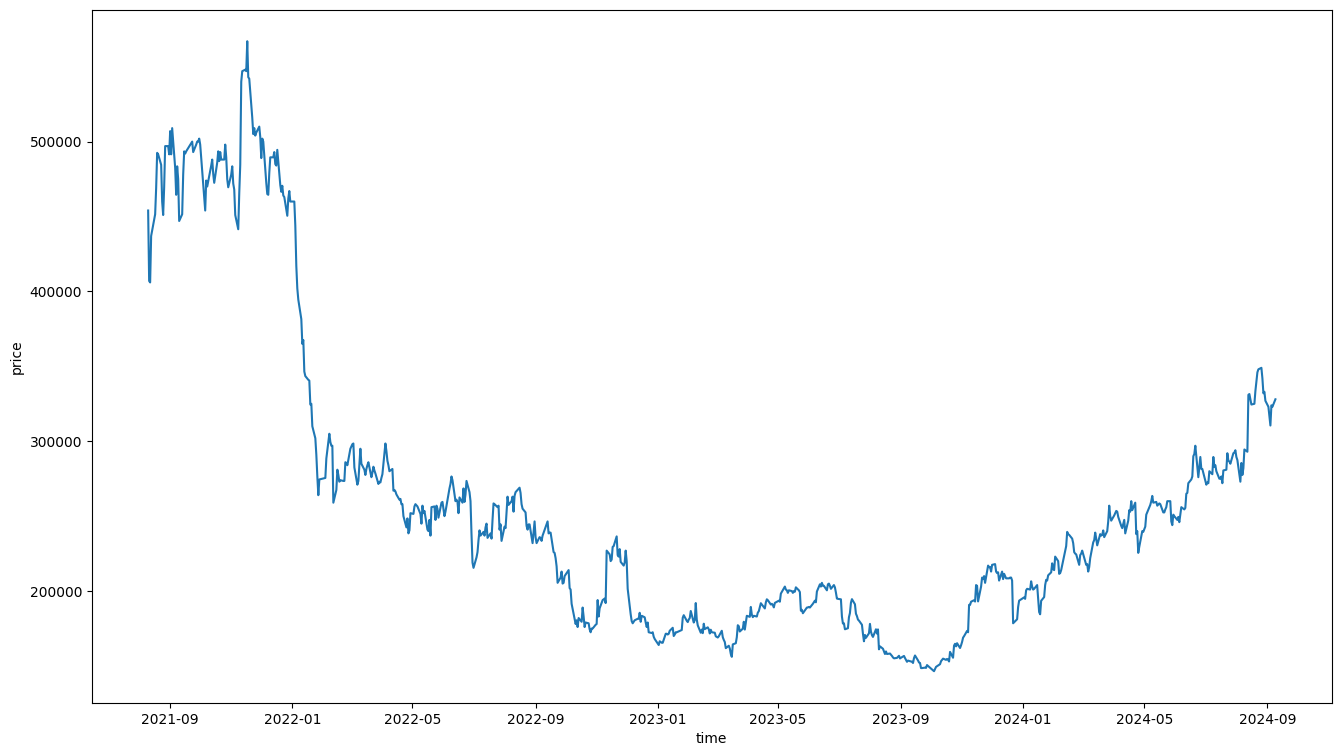

In [155]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

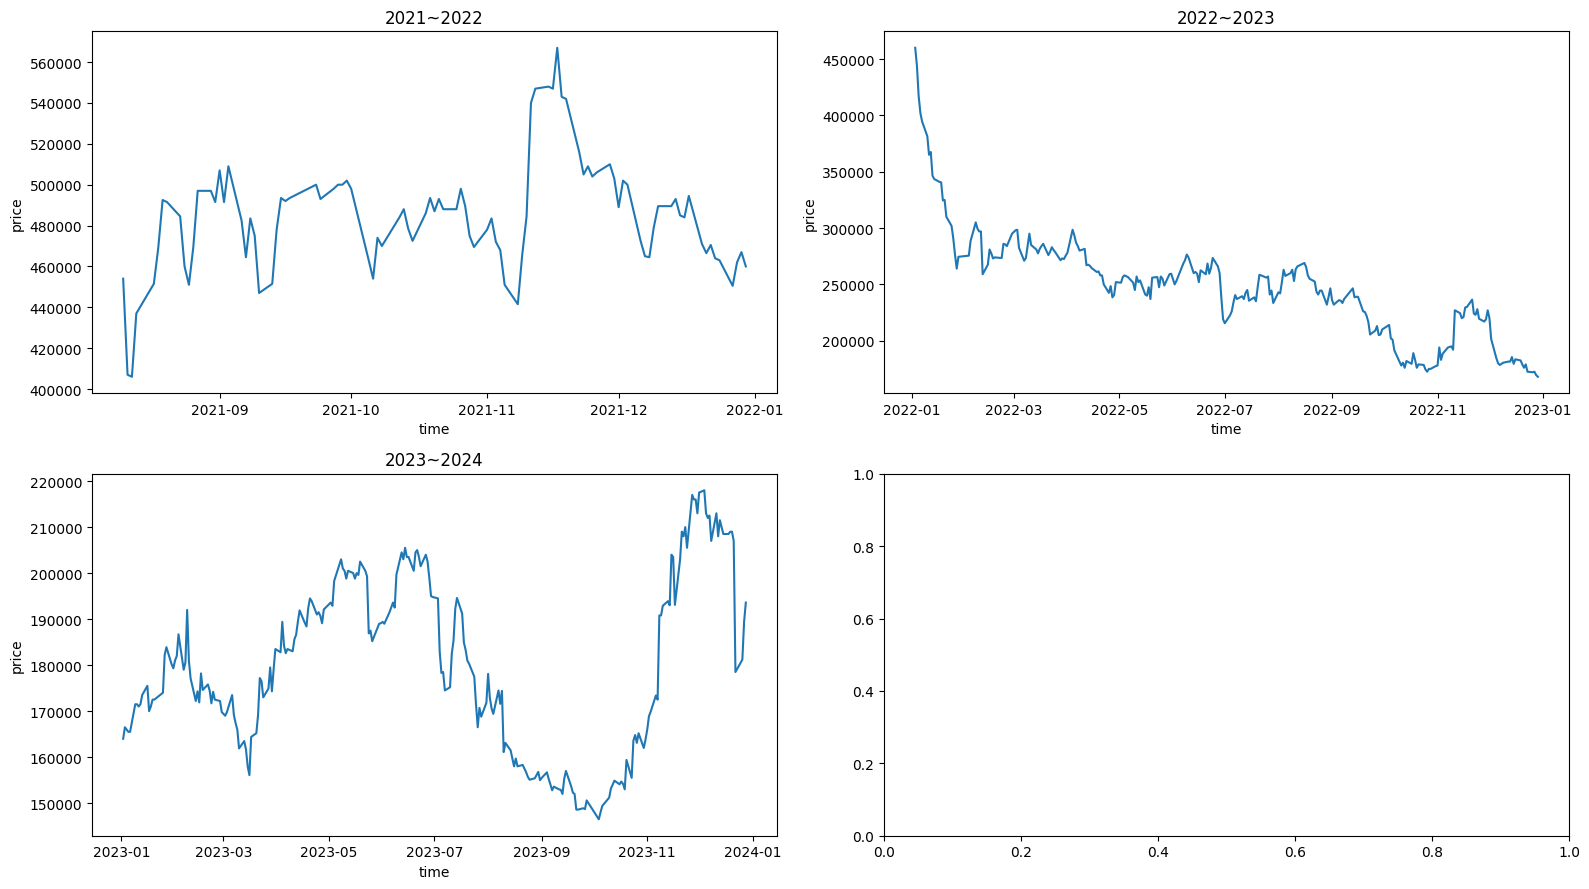

In [162]:
# time_steps = [['1990', '2000'],
#               ['2000', '2010'],
#               ['2010', '2015'],
#               ['2015', '2020']]

time_steps = [['2021', '2022'],
              ['2022', '2023'],
              ['2023', '2024']]


fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(3):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [163]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.71283385, 0.76771196, 0.63317583, 0.73127229, 1.        ],
       [0.70337982, 0.68873403, 0.64436707, 0.61950059, 0.31639924],
       [0.63129284, 0.62950058, 0.63690624, 0.61712247, 0.17868554],
       ...,
       [0.39139683, 0.41695703, 0.41432479, 0.42211653, 0.02963536],
       [0.42566769, 0.42973287, 0.43048993, 0.41973841, 0.01212579],
       [0.40794139, 0.41695703, 0.42178563, 0.43162901, 0.01424128]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [164]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [165]:
from sklearn.model_selection import train_test_split

In [166]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', axis=1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [167]:
x_train.shape, y_train.shape

((607, 4), (607,))

In [168]:
x_test.shape, y_test.shape

((152, 4), (152,))

In [169]:
x_train

,Open,High,Low,Volume
0,0.712834,0.767712,0.633176,1.000000
1,0.703380,0.688734,0.644367,0.316399
2,0.631293,0.629501,0.636906,0.178686
3,0.633656,0.687573,0.653071,0.320746
4,0.676199,0.721254,0.689132,0.226219
...,...,...,...,...
602,0.113921,0.120790,0.118627,0.003432
603,0.119357,0.130081,0.120119,0.009705
604,0.139683,0.146341,0.143248,0.023064
605,0.147956,0.139373,0.140761,0.009075


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [131]:
import tensorflow as tf

In [170]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [171]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [172]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [173]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [175]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [176]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.weights.h5')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [177]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
     18/Unknown 2s 6ms/step - loss: 0.0194 - mse: 0.0388
Epoch 1: val_loss improved from inf to 0.00078, saving model to tmp/ckeckpointer.weights.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0189 - mse: 0.0378 - val_loss: 7.7928e-04 - val_mse: 0.0016
Epoch 2/50
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - mse: 0.0077  
Epoch 2: val_loss improved from 0.00078 to 0.00052, saving model to tmp/ckeckpointer.weights.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - mse: 0.0078 - val_loss: 5.1979e-04 - val_mse: 0.0010
Epoch 3/50
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - mse: 0.0030 
Epoch 3: val_loss improved from 0.00052 to 0.00052, saving model to tmp/ckeckpointer.weights.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - mse: 0.0031 - val_loss: 5.1822e-04 - val_mse: 0.0010
Epoch 4/50
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9760e-04 - mse: 0.0020     
Epoch 4: val_loss did not improve from 0.00052
19/19 ━━━━━━━━━━━━━━━━

저장한 ModelCheckpoint 를 로드합니다.

In [178]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [179]:
pred = model.predict(test_data)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [180]:
pred.shape

(132, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

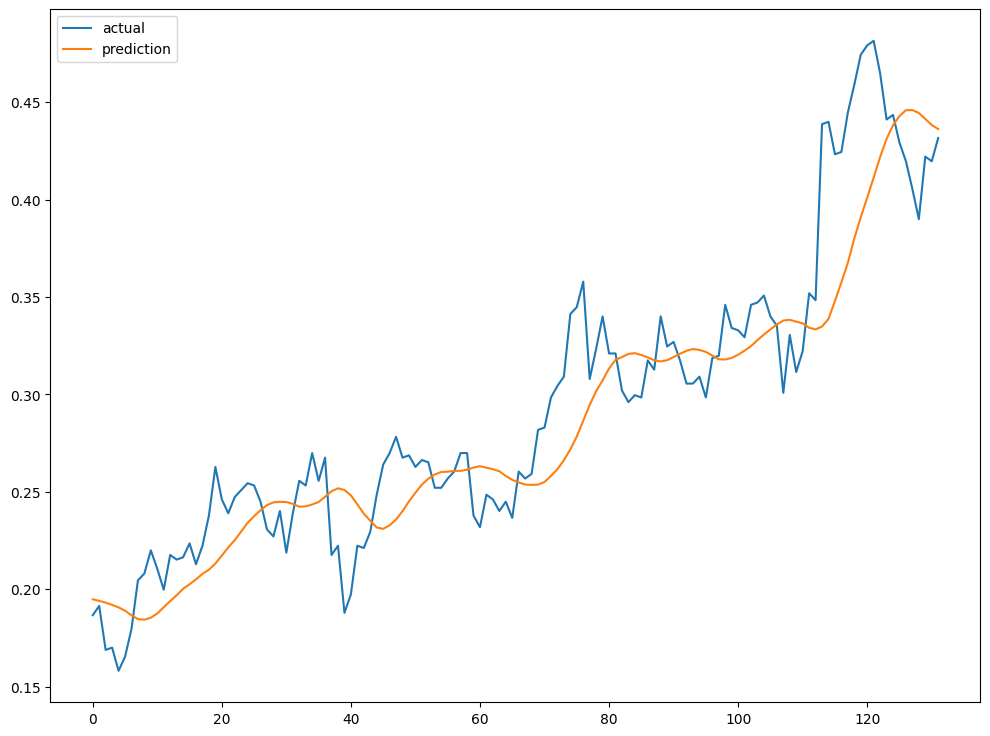

In [181]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()